# Huang1980 for Twilite and Image-Derived Input Functions

## Setup

In [1]:
# system functions that are always useful to have
import time, sys, os
from pprint import pprint

try:
    import numpy as np
    print("numpy is available")  # numpy is available; Jupyter linter has an issue with numpy
except ImportError:
    print("numpy is not available")
# import numpy as np 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


numpy is available


In [2]:
from PETUtilities import PETUtilities
from IOImplementations import BaseIO
from RBCPartition import RBCPartition
from InputFuncData import InputFuncData
from Huang1980Context import Huang1980Context

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# everything is decay corrected

kerndir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "kernels")
kern = os.path.join(kerndir, "kernel_hct=46.8.nii.gz")

fdgdir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421155709", "pet")
pet = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames_timeAppend-165-ParcSchaeffer-reshape-to-schaeffer-schaeffer.nii.gz")

# no deconv., decay corrected, no recovery coefficient
idif_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif.nii.gz")
# deconv., decay corrected, no recovery coefficient
idif_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif-BoxcarIO-ideal.nii.gz")
idif = InputFuncData.nii_hstack(idif_deconv, idif_embed, t_crossover=300, output_format="fqfn")

# no deconv., decaying, measurements corrected to draw-times
twil_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-embed.nii.gz")
# deconv., decaying, measurements corrected to draw-times, duration ~ 470 sec
twil_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-RadialArteryIO-ideal.nii.gz")
twil = InputFuncData.nii_hstack(twil_deconv, twil_embed, t_crossover=300, output_format="fqfn")
twil = InputFuncData.decay_correct(twil, output_format="fqfn")

codir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421144815", "pet")
v1_idif = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-idif_martinv1.nii.gz")
v1_twil = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-twilite_martinv1.nii.gz")

parc_index = 25  # caudate ~ 26 (Matlab); thalamus ~ 6, 25 (Matlab)

RBCPartition t_crossover: 35


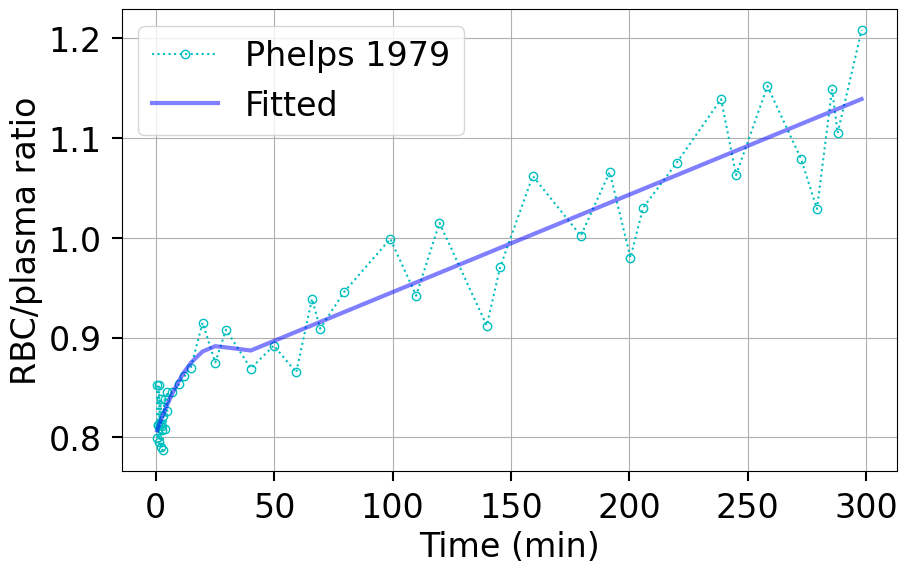

In [4]:
rbcp = RBCPartition(hct=46.8)
print(f"RBCPartition t_crossover: {rbcp.t_crossover}")
rbcp.plot()

## Inspect Huang1980Context twil

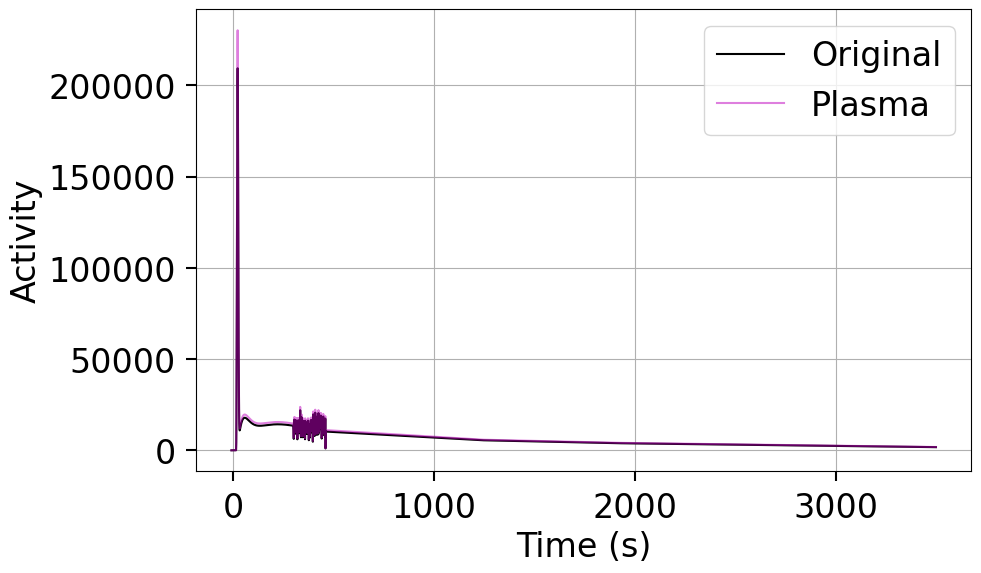

(474,)
'AUC: 22796288.208033822'


In [5]:
twil0 = BaseIO().nii_load(twil)
twil1 = rbcp.nii_wb2plasma(twil, output_format="niid")
twilp = rbcp.nii_wb2plasma(twil, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(twil0["timesMid"], twil0["img"], 'k-', label='Original')
plt.plot(twil1["timesMid"], twil1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(twil1["img"].shape)
auc = np.trapezoid(twil1["img"], twil1["timesMid"])
pprint(f"AUC: {auc}")

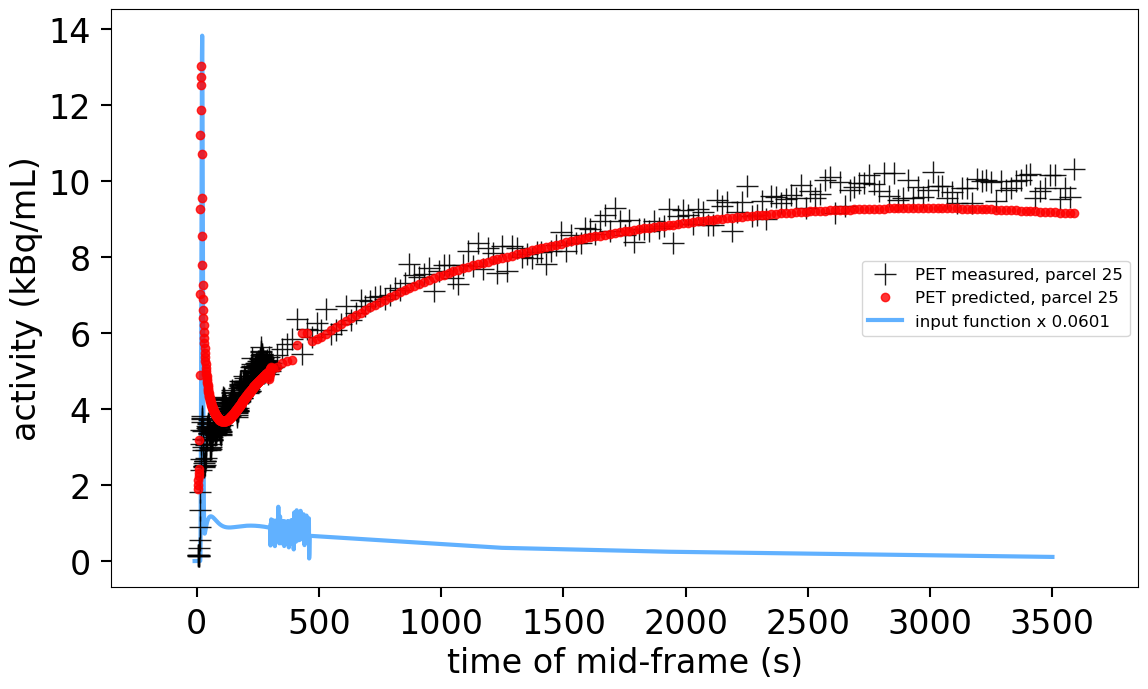

In [6]:
data_dict_twil = {
    "kernel_fqfn": kern,
    "input_func_fqfn": twilp,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_twil,
    "nlive": 100,
    "tag": "playground_Huang1980_twil"
}
truth_huang_twil = [
    3, 0.05, 40, 0.00015, 10.5, 0.02
]
huang_twil = Huang1980Context(data_dict_twil)
huang_twil.plotting.truths_plot(truths=truth_huang_twil, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [7]:
res_twil = huang_twil.solver.run_nested(print_progress=True, parc_index=parc_index)

9268it [2:19:26,  2.80s/it, batch: 10 | bound: 23 | nc: 57 | ncall: 469177 | eff(%):  1.975 | loglstar:   -inf < -193.025 < 798.377 | logz: 762.979 +/-  0.281 | stop:  2.239]                /Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:420: UserWarning: The slice sample interval was expanded more than 1000 times
  warnings.warn('The slice sample interval was expanded more '
/Users/jjlee/anaconda3/envs/dynesty12/lib/python3.12/site-packages/dynesty/sampling.py:685: UserWarning: Enabling doubling strategy of slice sampling from Neal(2003)
  warnings.warn('Enabling doubling strategy of slice '
21129it [6:04:31,  1.04s/it, batch: 19 | bound: 18 | nc: 1 | ncall: 1297270 | eff(%):  1.620 | loglstar: 792.228 < 798.746 < 797.210 | logz: 759.470 +/-  0.219 | stop:  0.974]    


DynestyPlotting.results_plot.dyplot.runplot: caught a ValueError: Axis limits cannot be NaN or Inf


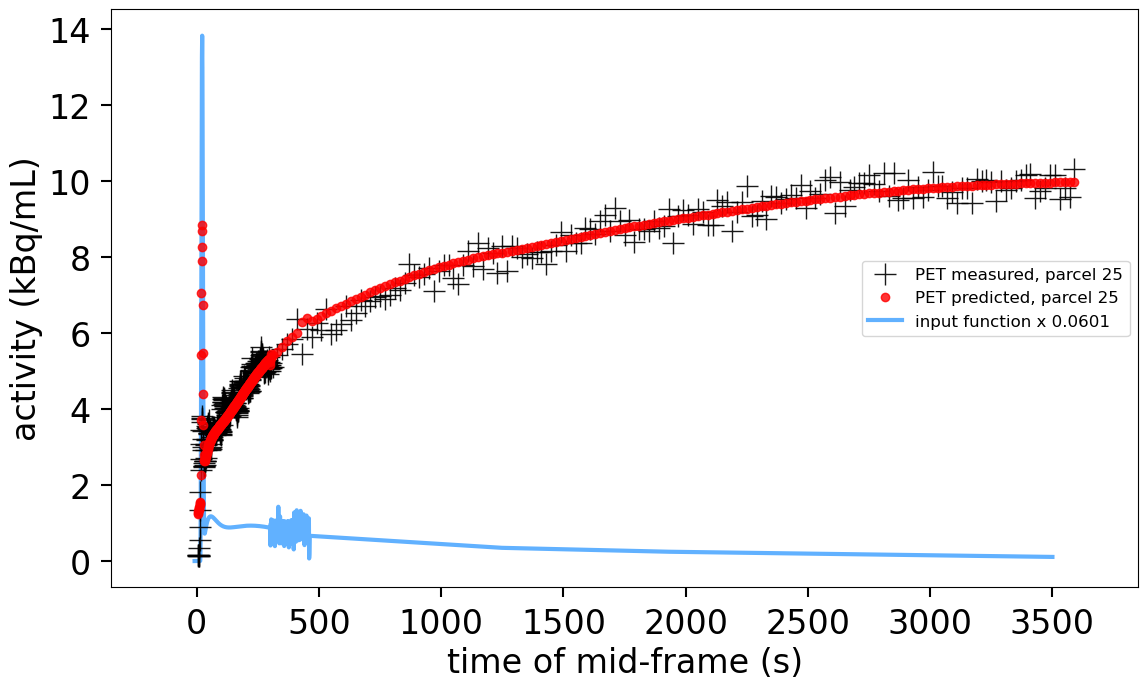

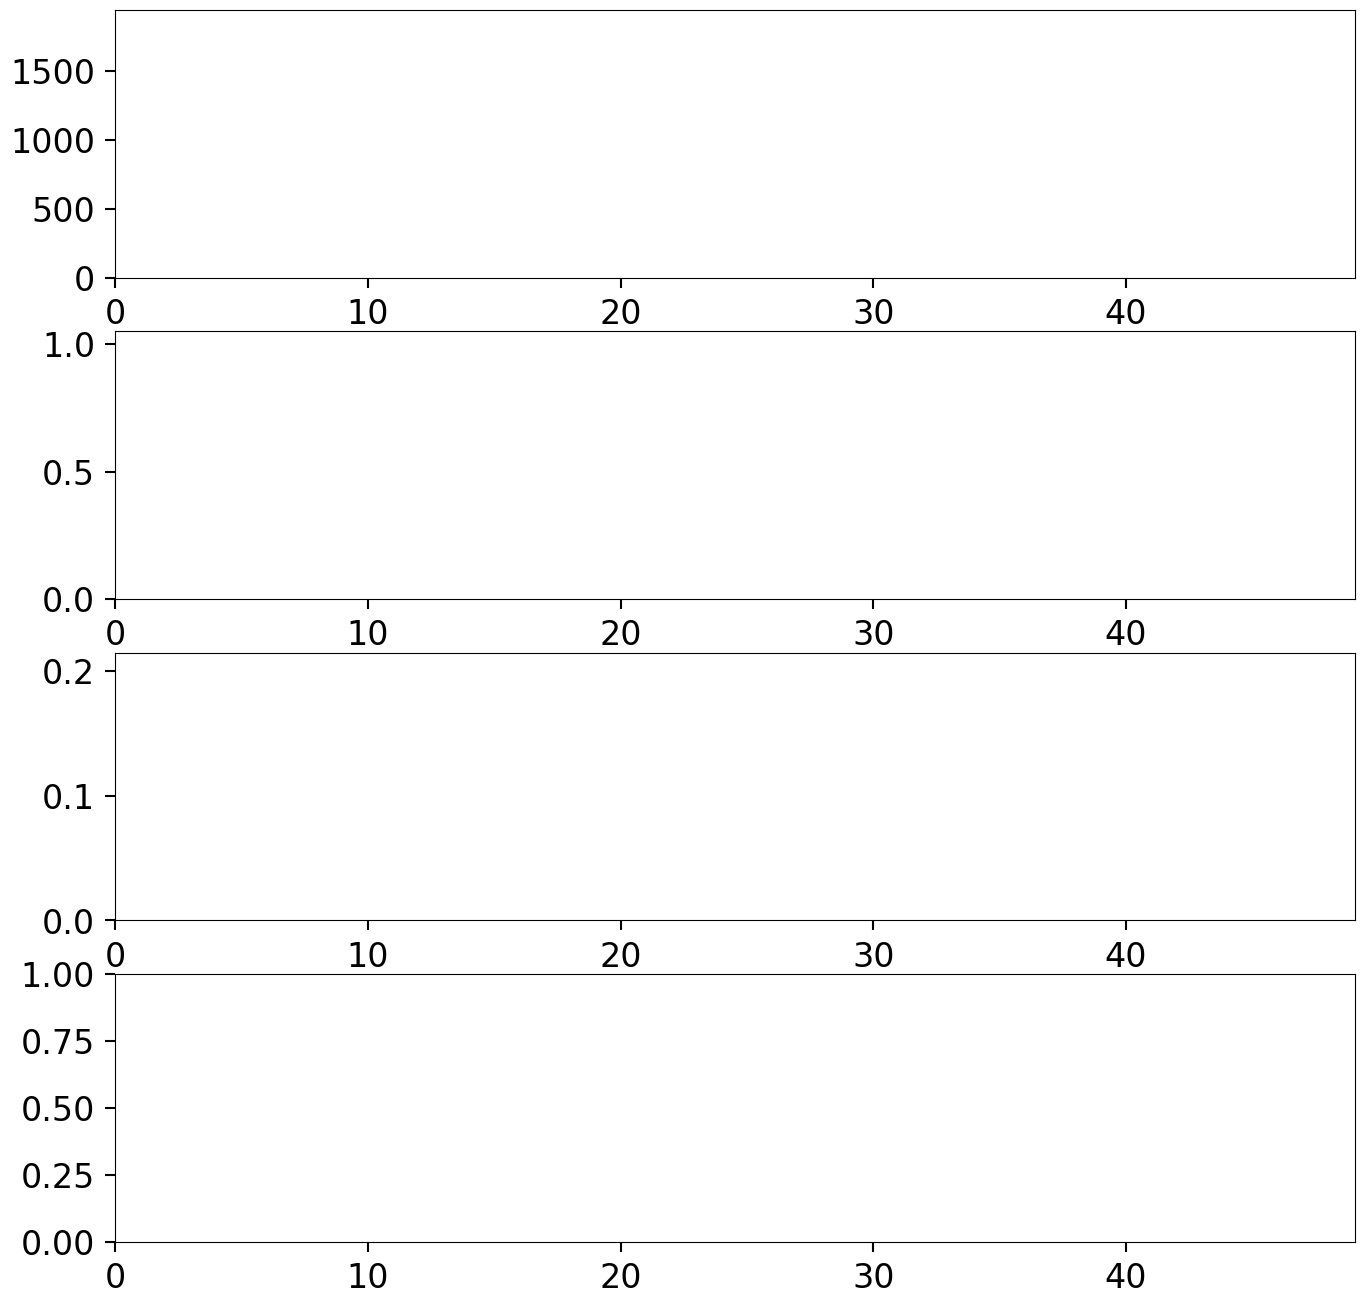

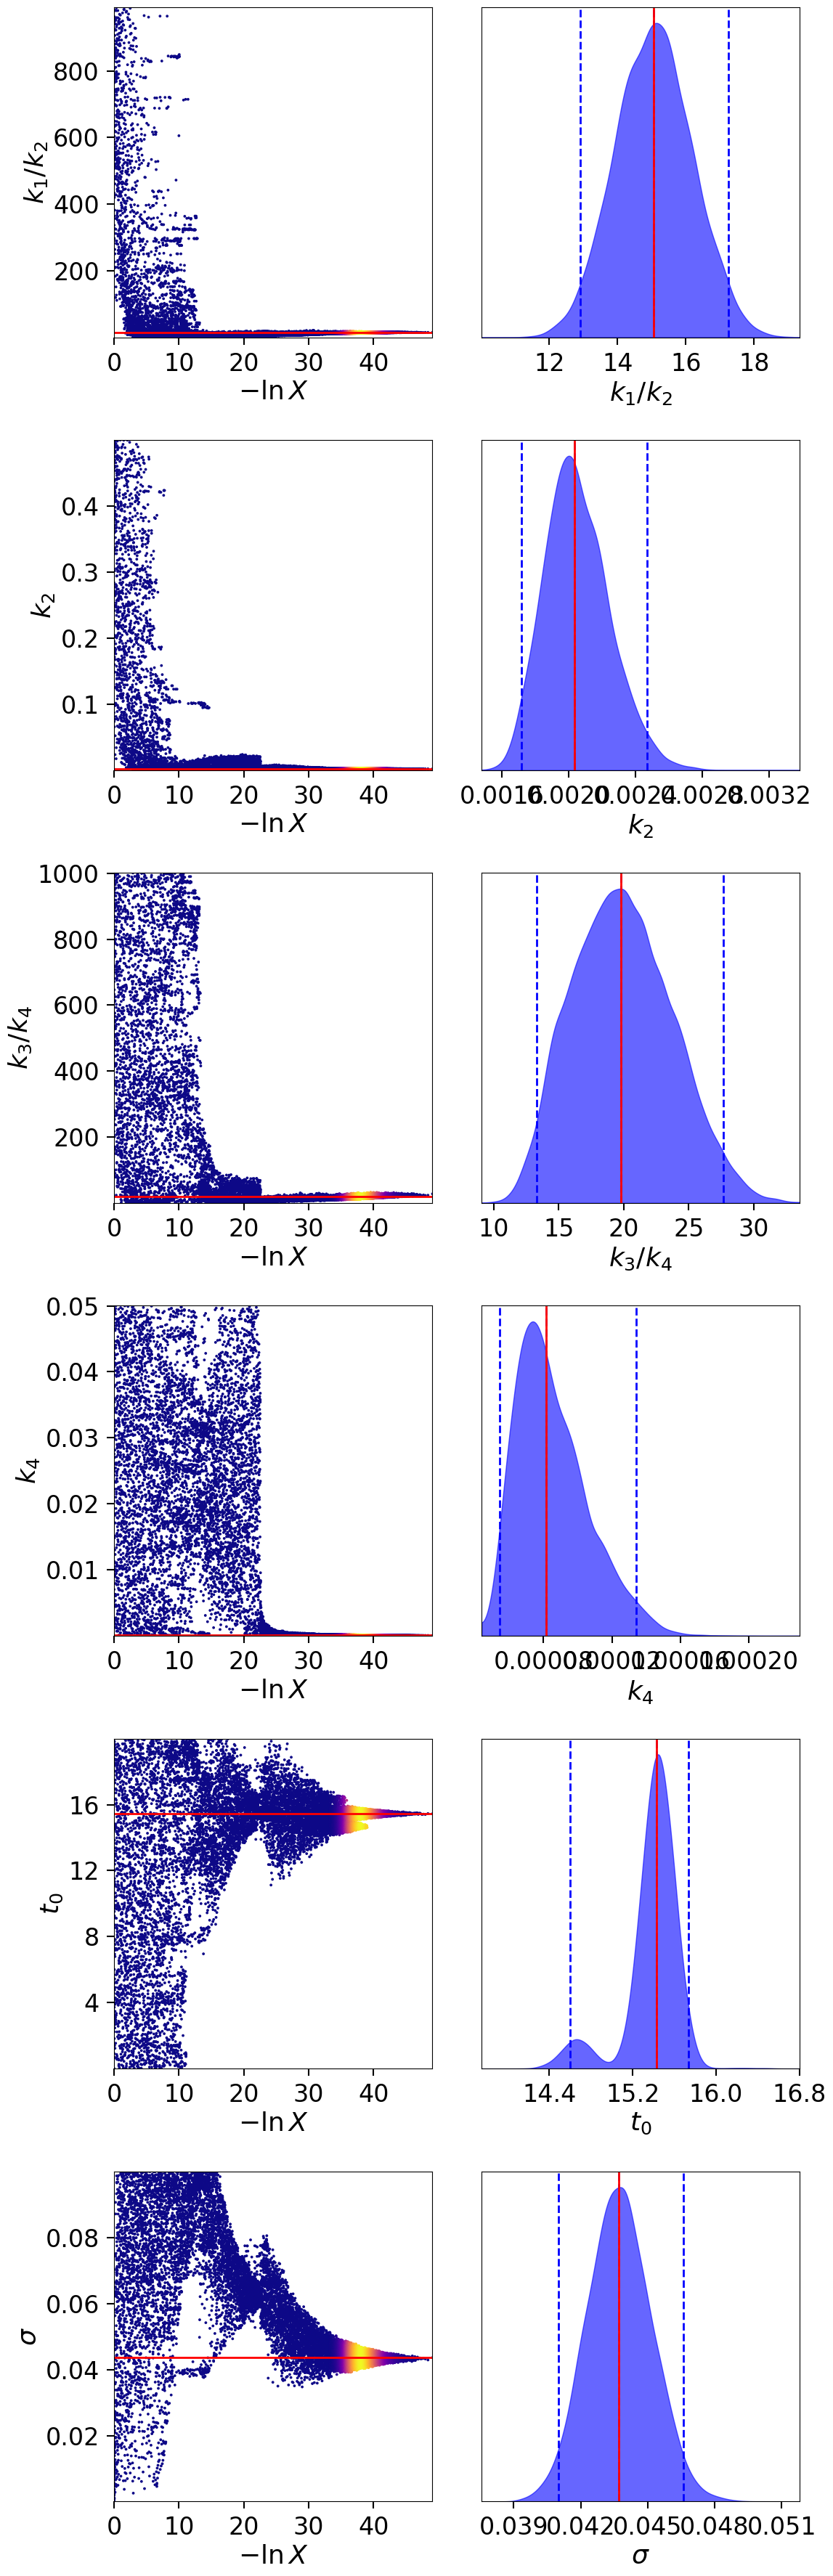

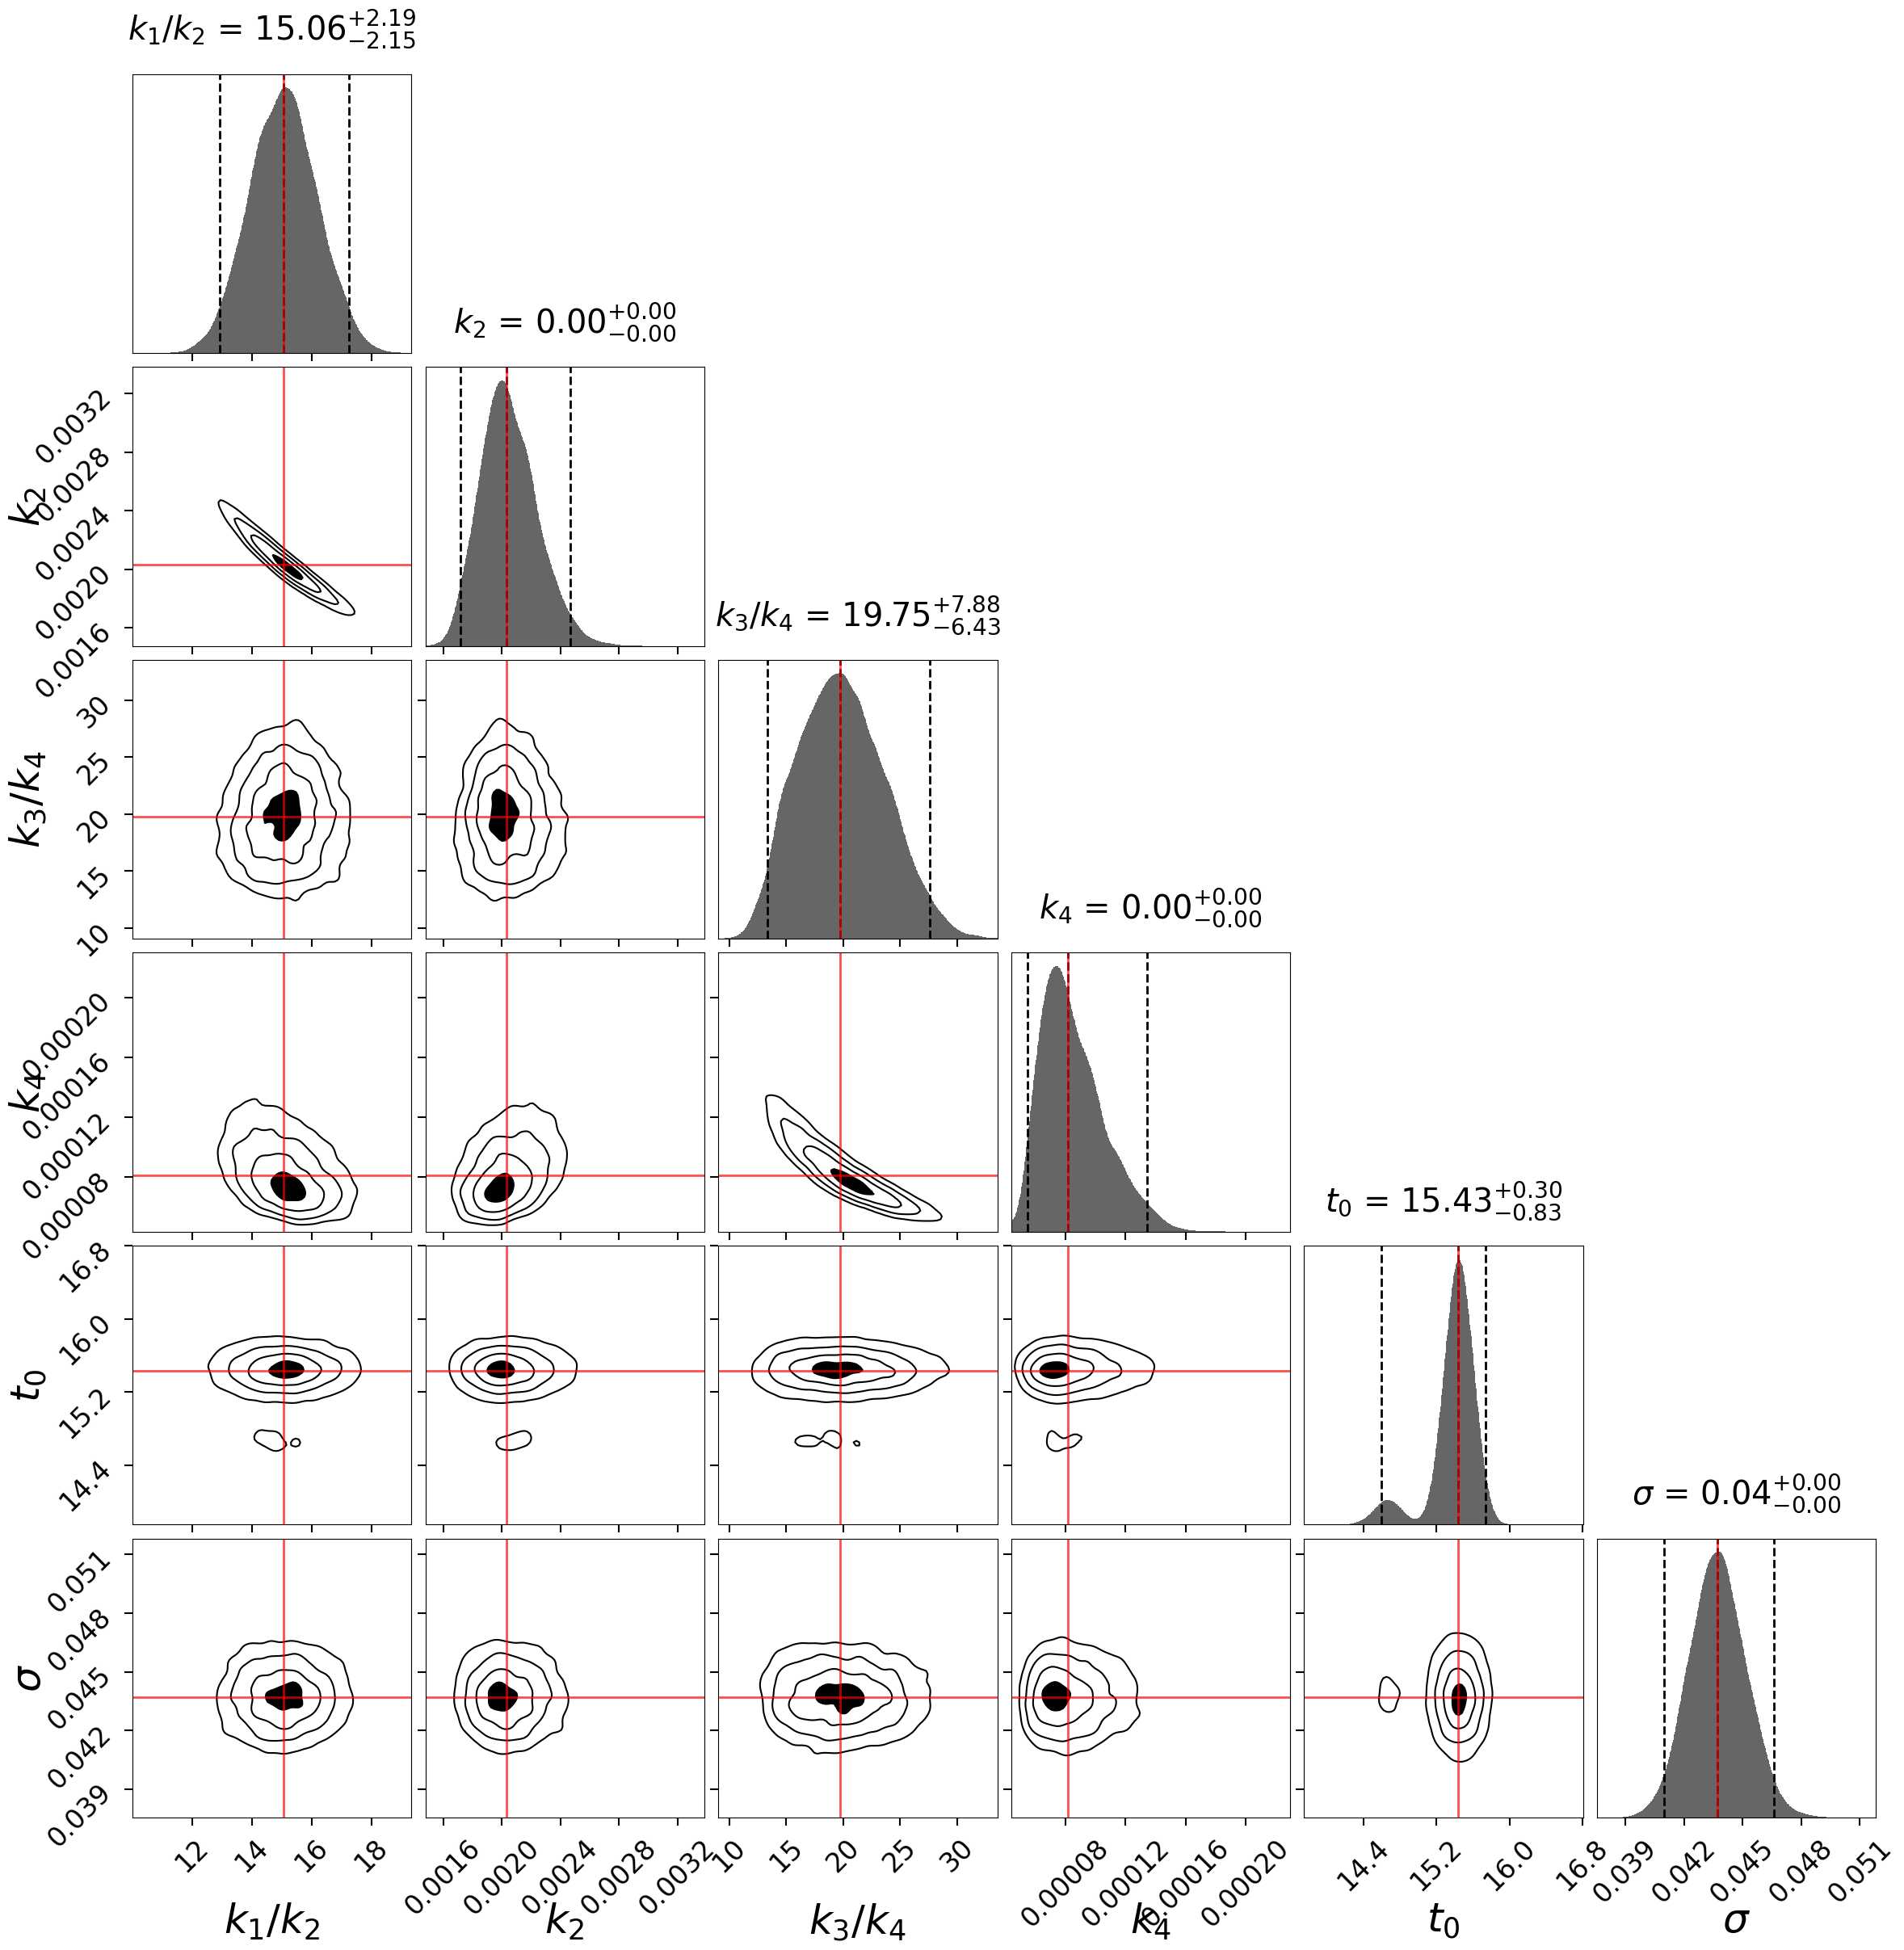

In [8]:
huang_twil.plotting.results_plot(tag="playground_Huang1980_twil", parc_index=parc_index)

ValueError: v must be 1-dimensional array of length 6

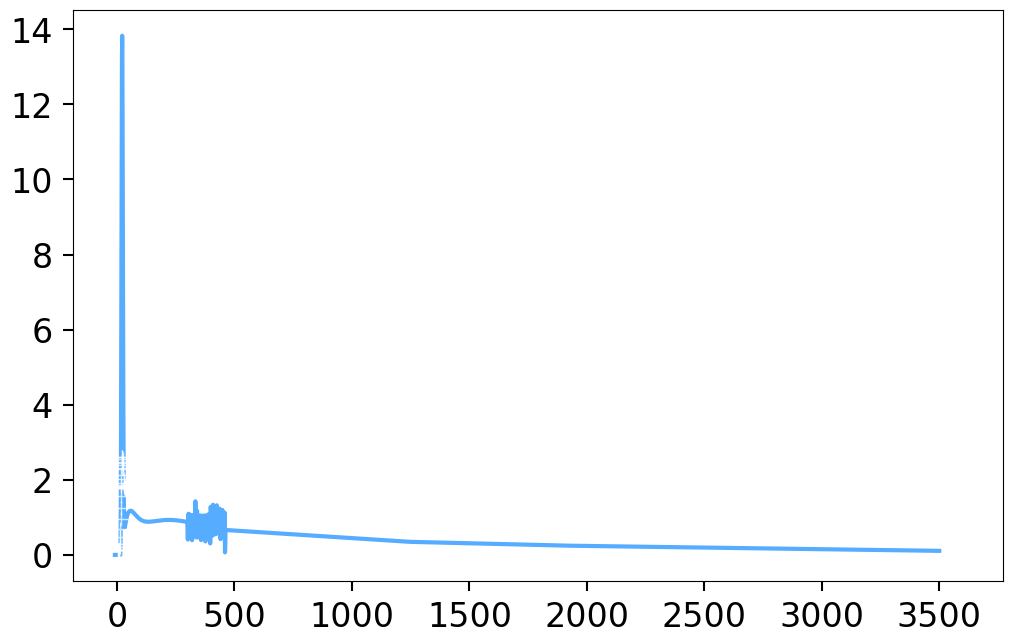

In [9]:
huang_twil.plotting.parcs_plot()

## Inspect Huang1980Context idif

In [ ]:
idif0 = BaseIO().nii_load(idif)
idif1 = rbcp.nii_wb2plasma(idif, output_format="niid")
idifp = rbcp.nii_wb2plasma(idif, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(idif0["timesMid"], 1.8509 * idif0["img"], 'k-', label='Original')
plt.plot(idif1["timesMid"], 1.8509 * idif1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(idif1["img"].shape)
auc = np.trapezoid(idif1["img"], idif1["timesMid"])
pprint(f"AUC: {auc}")

In [ ]:
data_dict_idif = {
    "input_func_fqfn": idifp,
    "tissue_fqfn": pet,
    "v1_fqfn": v1_idif,
    "nlive": 100,
    "tag": "playground_Huang1980_idif"
}
truth_huang_idif = [
    1.2, 0.05, 70, 0.00015, 10.5, 0.02
]

huang_idif = Huang1980Context(data_dict_idif)
huang_idif.plotting.truths_plot(truths=truth_huang_idif, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [9]:
res_idif = huang_idif.solver.run_nested(print_progress=True, parc_index=parc_index)

In [ ]:
huang_idif.plotting.results_plot(tag="playground_Huang1980_idif", parc_index=parc_index)

In [ ]:
huang_idif.plotting.parcs_plot()

In [ ]:
huang_twil.data.print_truths()
huang_idif.data.print_truths()

In [ ]:
pprint(huang_twil.solver.truths)
pprint(huang_idif.solver.truths)